<a href="https://colab.research.google.com/github/cbarron100/Neural-Networks/blob/main/RegressionWithKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the necessay packages, this was given to me

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import randint as sp_randint

import tensorflow as tf
from tensorflow	import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.metrics import r2_score, mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV

Sorting out data. First import it and take a quick look at the data. Describe, info, and value counts was used. 'Serial No' seemed weird and probably will not aid in the regression problem. There were now object columns and all seemed good so let move on. Last step was making feature and label Dataframes


In [4]:
df = pd.read_csv('/admissions_data.csv')
#print(df.info())
#print(df.describe())

df = df.drop(['Serial No.'], axis = 1)
feature_col = df.columns[:-1]
label = df.columns[-1:]
#print(feature_col)
#print(label)

X = df[feature_col]
y = df[label]

Train, Test split. We have also scaled the X values using a Normaliser. I did not want to use StandardScaler because I wanted all the value to be over 0 but maybe that was a bad choice can change later.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
scaler = Normalizer()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#print(X_triain.scaled.describe())

Time to make the neural network. Started with ReLU as activation and went from 7 to 64 to 8 to 1 (in the begining).

We need to initialise a optimzer, we will start with Adam.

After some initial testing we have a pretty good idea oh the number of epochs are good (40) and the learning rate roughtly 0.0001.

Now we can add an EarlyStopping object to prevent overfitting



In [6]:
def model_design(training, learning):
  model = Sequential() #initialise the model
  input = layers.InputLayer(input_shape = (training.shape[1]))
  #input layer has the same number of inputs as the feature amount
  model.add(input) ## place the input layer on the model
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(8, activation = 'relu')) ##sigmoid might be better
  model.add(layers.Dense(1)) ## output layer


  optim = Adam(learning_rate = learning) # 0.1 to start
  model.compile(loss = 'mse', metrics = ['mae'], optimizer = optim)
  return model


Now we can train the model


In [32]:
#my_model.fit(X_train_scaled, y_train, epochs = 100, batch_size = 1, verbose = 1)
#res_mse, res_mae = my_model.evaluate(X_test_scaled, y_test, verbose = 0)
#print('Result MSE: ', res_mse)
#print('Result MAE: ', res_mae)

We have no trained a model with certain parameters and the resulting MSE = 0.02 with a MAE 0.115. Let's take a look at how the LR changes the learning patern of the model we will try 4 values  [1, 0.1, 0.01, 0.001]. We will look at the other hyperparameters after.

First iteration of the learning with different Learning Rates showed we didn't need 100 epochs. So we lowered the number of epochs to 30

This caused for unusual result so increased the Epochs back to 100, and changed the learning rates to [1E-2, 1E-4, 1E-7]


After adding the stop we saw some new results and the learning rate grpahs changed. The epochs were too low for there to be reasonable results. So increased them again.

EarlyStopping stoped the learning at [33, 41 , 34] for the learning rates, respectively.

The lowest loss was with 1E-2 so will be going with that from now on.

-----------------------------------------------------
Experimenting with batch sizes now [2, 6, 10, 14]

Early stopping stopped the learning at [19, 38, 29, 45], respectively.

Since there was no large difference between the batch sizes I will be going with batch size 2 moving forward.



Epoch 19: early stopping
Epoch 38: early stopping
Epoch 29: early stopping
Epoch 45: early stopping


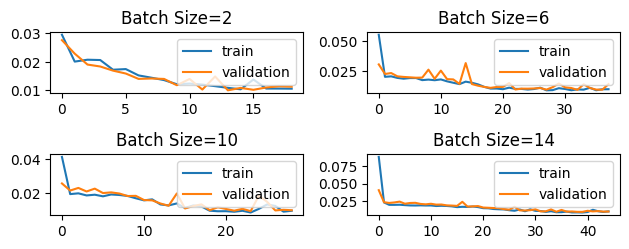

In [11]:
lr_options = 1E-2
num_epoch = 50
batch_size = 2



def fit_model(f_train, l_train, learning_rate, num_epochs, bs):
    #build the model
    my_model = model_design(f_train, learning_rate)
    #train the model on the training data
    stop = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience  = 5) # patience will be set to 5 for number of epochs to continue after plateau
    history = my_model.fit(f_train,
                           l_train,
                           epochs = num_epochs,
                           batch_size = bs,
                           verbose = 0,
                           validation_split = 0.2,
                           callbacks = [stop])
    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Batch Size=' + str(bs))
    plt.legend(loc="upper right")

for i in range(len(batch_size)):
  plot_no = 420 + (i + 1)
  plt.subplot(plot_no)
  fit_model(X_train_scaled, y_train, lr_options, num_epoch, batch_size[i])
plt.tight_layout()
plt.show()


Now that we have all the values for a model let's create a new model with the new values.
- batch size = 2
- lr = 1E-2
- epochs = 50

We can also compare this to a DummyRegressor for a check

In [15]:
dummy_reg = DummyRegressor(strategy='mean')
dummy_reg.fit(X_train_scaled, y_train)
dummy_pred = dummy_reg.predict(X_test_scaled)

new_best_model = model_design(X_test_scaled, 1E-2)
stop = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience  = 5) # patience will be set to 5 for number of epochs to continue after plateau
new_best_model.fit(X_train_scaled,
                   y_train,
                   epochs = 50,
                   batch_size = 2,
                   verbose = 0,
                   validation_split = 0.2,
                   callbacks = [stop])
predictions = new_best_model.predict(X_test_scaled)

MAE_basline  = mean_absolute_error(y_test, dummy_pred)
MAE_my_model = mean_absolute_error(y_test, predictions)

print('Baseline MAE:', MAE_basline)
print('My model MAE:', MAE_my_model)

Epoch 22: early stopping
4/4 [==============================] - 0s 2ms/step
Baseline MAE: 0.116268
My model MAE: 0.08660066645145417


We have been able to improve the model from roughly 0.11 to 0.0866 MAE. That is a 21.3% improvement through manually changing the hyperparameters. We have even been able to beent he baseline regressor which is also at 0.11 MAE.

Now lets try and imrove our model using a RandomSearchCV object.

In [25]:
random_search_model = model_design(X_train_scaled, 1E-2)

param_grid = {'batch_size': sp_randint(2, 16), 'nb_epoch': sp_randint(10, 50)}
random_search = RandomizedSearchCV(estimator = random_search_model,
                          param_distributions=param_grid,
                          scoring = make_scorer(mean_absolute_error, greater_is_better=False),
                          n_iter = 12
                          )
#needs to be wrapped in a KerasRegressor wrapper but I cannot find the module to import
random_result = random_search.fit(X_train_scaled, y_train)
random_search_prediction = random_search.predict(X_test_scaled)

random_search_MAE = mean_absolute_error(y_test, random_search_prediction)

print('Random Search Algorithim:', random_search_MAE)



TypeError: Cannot clone object '<keras.src.engine.sequential.Sequential object at 0x7b29d6da3f10>' (type <class 'keras.src.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.